In [63]:
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt 
import seaborn as sns 
import re
import warnings; warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS
import json 
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from transformers import BertTokenizer
import numpy as np

In [2]:
DATASET_LOC = 'data/reddit_posts_20251212_035106.parquet'

In [3]:
df = pd.read_parquet(DATASET_LOC)

In [4]:
df.head()

,post_id,title,subreddit
0,1pkhhxb,"Even the man behind ChatGPT, OpenAI CEO Sam Al...",technology
1,1pkh69t,"Palantir sues CEO of rival AI firm Percepta, a...",technology
2,1pkg053,'Architects of AI' named Time Magazine's Perso...,technology
3,1pkfqa0,Sam Altman expects OpenAI to exit ‘code red’ b...,technology
4,1pkfpmf,Broadcom reveals its mystery $10 billion custo...,technology


In [5]:
df['subreddit'].value_counts()

subreddit
entertainment            997
technology               989
science                  987
politics                 986
ArtificialInteligence    962
Name: count, dtype: int64

In [49]:
df = df.sample(frac = 1.0)

In [6]:
test_size = 0.2 
train_df, val_df = train_test_split(df, test_size = test_size, stratify = df['subreddit'], random_state = 13)
                                    

In [7]:
train_df['subreddit'].value_counts()

subreddit
entertainment            797
technology               791
politics                 789
science                  789
ArtificialInteligence    770
Name: count, dtype: int64

In [8]:
(val_df['subreddit'].value_counts() * (1-test_size))/(test_size)

subreddit
entertainment            800.0
science                  792.0
technology               792.0
politics                 788.0
ArtificialInteligence    768.0
Name: count, dtype: float64

## EDA 

Let us first visualise the number of examples per subreddit. 

In [9]:
counter = Counter(df['subreddit'])
counter.most_common()

[('entertainment', 997),
 ('technology', 989),
 ('science', 987),
 ('politics', 986),
 ('ArtificialInteligence', 962)]

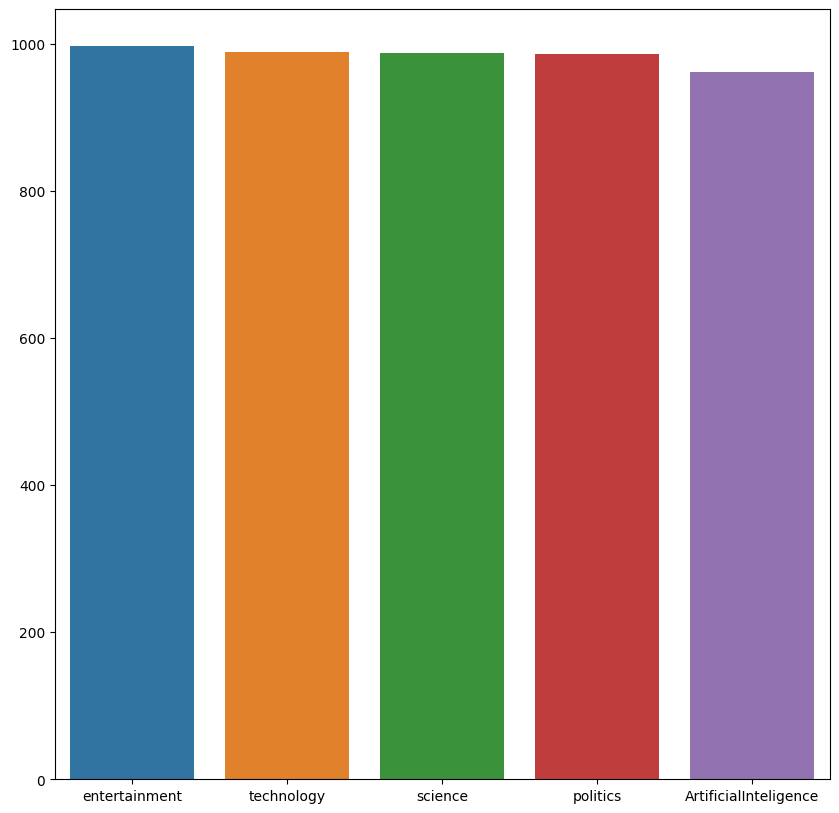

In [10]:
subreddit, counts = zip(*counter.most_common())
plt.figure(figsize = (10,10))
sns.barplot(x = list(subreddit), y = list(counts), hue = list(subreddit))
plt.show()

In [11]:
subreddits = df['subreddit'].unique().tolist()

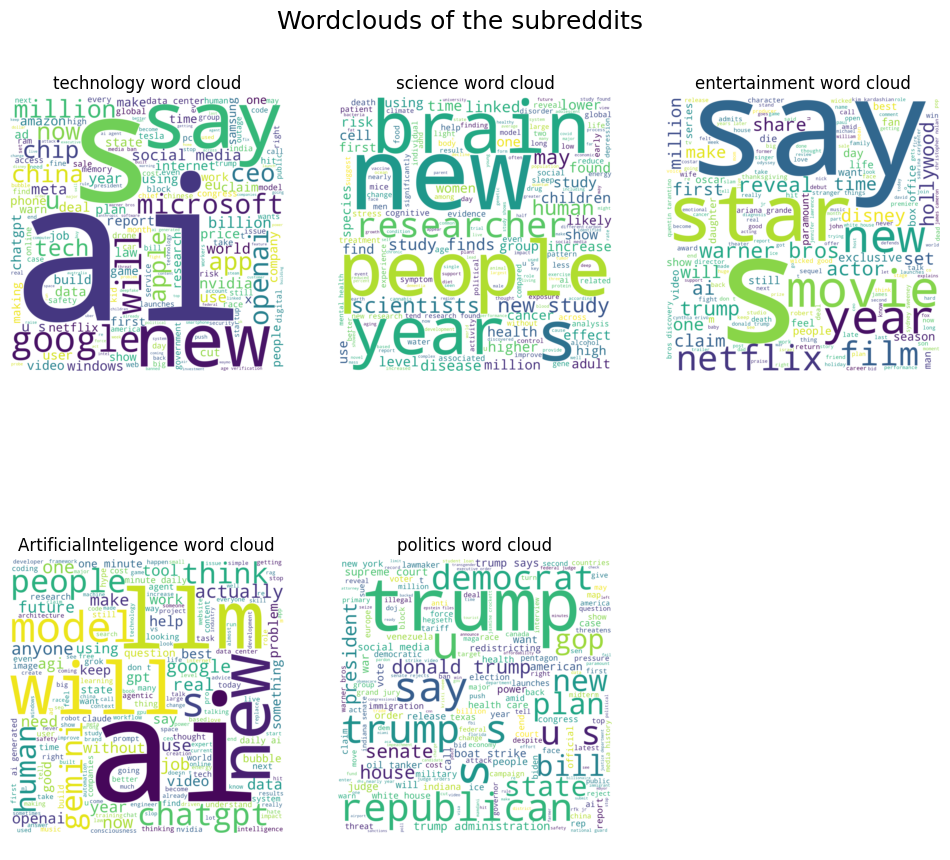

In [12]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 10))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Wordclouds of the subreddits", fontsize=18, y=0.95)

for sub, ax in zip(subreddits, axs.ravel()):
    stopwords = set(STOPWORDS)
    text = ' '.join(df[df['subreddit'] == sub]['title'].astype('str').tolist())
    text = text.lower()
    text = ' '.join(word for word in text.split() if word not in stopwords)
    
    wordcloud = WordCloud(width=2000, height=2000, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f"{sub} word cloud")
    ax.axis('off')

axs.ravel()[-1].axis('off')

plt.show()
        

In [14]:
def clean_text(text):
    stopwords = set(STOPWORDS)
    text = text.lower()
 
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text) 
    text = re.sub("[^A-Za-z0-9]+", " ", text)
    text = text.strip()
    text = re.sub(r"http\S+", "", text)
    return text 
    

In [15]:
original_df = df.copy()
df['title'] = df['title'].map(clean_text)

In [17]:
print(original_df['title'][0])
print(df['title'][0])

Even the man behind ChatGPT, OpenAI CEO Sam Altman is worried about the ‘rate of change that’s happening in the world right now’ thanks to AI
even man behind chatgpt openai ceo sam altman worried rate change s happening world right now thanks ai


In [18]:
df = df.drop(columns = ['post_id'], axis = 1) 
df = df.dropna()

In [22]:
class_to_index = {k:i for i, k in enumerate(subreddits)}
class_to_index

{'technology': 0,
 'science': 1,
 'entertainment': 2,
 'ArtificialInteligence': 3,
 'politics': 4}

In [35]:
index_to_class = {v:k for k,v in class_to_index.items()}
index_to_class

{0: 'technology',
 1: 'science',
 2: 'entertainment',
 3: 'ArtificialInteligence',
 4: 'politics'}

In [41]:
def encode(indices, class_to_index):
    return [class_to_index[index] for index in indices]


In [44]:
encode(df.sample(5)["subreddit"].values, class_to_index=class_to_index)

[0, 1, 2, 3, 2]

In [47]:
df['subreddit'] = df['subreddit'].map(class_to_index)

In [50]:
df

,title,subreddit
294,europe forges ahead big tech crackdown x fine ...,0
1192,little known culture bronze age turkey might m...,1
445,google s agentic ai wipes user s entire hdd wi...,0
2634,box office wicked good opens record smashing 1...,2
1350,assessment potentially toxic elements pollutio...,1
...,...,...
1756,pain hypersensitivity reduced lrrc8a restraine...,1
4429,democrats say hegseth balked call full video b...,4
1442,skipping breakfast significantly linked higher...,1
4117,newsom trolls white house sobbing trump handcuffs,4


In [51]:
def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]

In [52]:
decode(df.head()["subreddit"].values, index_to_class=index_to_class)

['technology', 'science', 'technology', 'entertainment', 'science']

In [56]:
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    encoded_inputs = tokenizer(batch['title'].tolist(), padding = 'longest',return_tensors = 'np')
    return dict(ids=encoded_inputs["input_ids"], masks=encoded_inputs["attention_mask"], targets=np.array(batch["subreddit"]))

In [61]:
def preprocess(df, class_to_index:dict):
    df['title'] = df['title'].map(clean_text)
    df = df.drop(columns = ['post_id'], axis = 1) 
    df = df.dropna()
    df['subreddit'] = df['subreddit'].map(class_to_index)
    outputs = tokenize(df)
    return outputs
    

In [64]:
train_inputs = preprocess(train_df, class_to_index)
val_inputs = preprocess(val_df, class_to_index)